In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
X, y = pd.read_csv('task-1-brain-age-prediction/X_train.csv'), pd.read_csv('task-1-brain-age-prediction/y_train.csv')

In [83]:
X.drop(labels='id', axis=1, inplace=True)
y.drop(labels='id', axis=1, inplace=True)

In [84]:
# data imputing with the median
from sklearn.impute import KNNImputer

X_index, X_columns = X.index, X.columns
knn_impute = KNNImputer(n_neighbors=5, weights='distance')
X = knn_impute.fit_transform(X)

In [85]:
X = pd.DataFrame(X, index=X_index, columns=X_columns)

In [86]:
print(X.shape)
X = X.drop_duplicates()
print(X.shape)

(1212, 832)
(1212, 832)


In [87]:
# Remove columns with zero variance
mask_ = X.var(axis=0) != 0
X = X.loc[:, mask_]
print(X.shape)

(1212, 828)


In [88]:
print(X.isnull().sum().sum()) # check imputer

0


In [90]:
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test.drop(labels='id', axis=1, inplace=True)
X_test = knn_impute.transform(X_test)

X_test = X_test[:, mask_]

In [91]:
from sklearn.preprocessing import RobustScaler

rbc = RobustScaler()
X_scaled = rbc.fit_transform(X)
X_test_scaled = rbc.transform(X_test)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


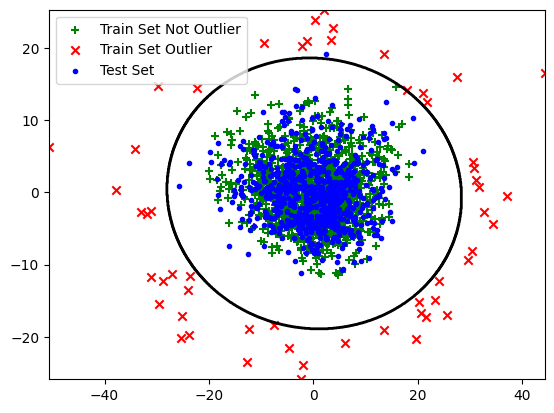

In [92]:
# Outlier Detection
# Some motivation for this approach --> since we're trying to maximize 
# r2 score on the test set and we don't have the gt label for the test set
# we only have to consider the points int the training set that are in accordance with 
# the points in the test set, i.e the outliers are the points which are far of the elliptic
# envelope decision boundary

from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

fig, ax = plt.subplots()

pca = PCA(n_components=2)
X_project = pca.fit_transform(X_scaled)
X_test_project = pca.transform(X_test_scaled)

# Outlier analysis --> EllipticEnvelope (Gaussian)
xx, yy = np.meshgrid(np.linspace(X_project[:, 0].min(), \
X_project[:, 0].max(), 1000), np.linspace(X_project[:, 1].min(), \
    X_project[:, 1].max(), 1000))

elliptic = EllipticEnvelope(contamination=0.044)
outliers = elliptic.fit_predict(X_project)
mask_outliers_out = outliers != -1
X_project_not_outliers = X_project[mask_outliers_out, :]
X_project_outliers = X_project[~mask_outliers_out, :]

ax.scatter(X_project_not_outliers[:, 0], X_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(X_project_outliers[:, 0], X_project_outliers[:, 1], marker='x', color='red')
ax.scatter(X_test_project[:, 0], X_test_project[:, 1], marker='.', color='blue')
Z = elliptic.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
ax.legend(['Train Set Not Outlier', 'Train Set Outlier', 'Test Set'])

plt.show()

In [93]:
X = X.loc[mask_outliers_out, :]

In [95]:
y = y.loc[mask_outliers_out, :]

In [96]:
from sklearn.feature_selection import mutual_info_regression
mutual_info_w_target = mutual_info_regression(X, y.squeeze())
X = X.loc[:, mutual_info_w_target > 0.1]

In [97]:
X.shape

(1158, 31)

In [99]:
def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr
mask_multicorr = filter_multicolinearity(X, 0.8)
X = X.loc[:, mask_multicorr]

In [100]:
print(X.shape)

(1158, 28)


In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [102]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler

svr_std = Pipeline([ 
    ('scaler', RobustScaler()),
    ('svr', SVR())
])
param_grid = { 
    'svr__kernel' : ['poly', 'rbf', 'sigmoid'], 
    'svr__gamma' : ['scale', 'auto'], 
    'svr__C': [1e-1, 1, 1e1, 1e2]
}

grid = RandomizedSearchCV(svr_std, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

svr_std_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, svr_std_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, svr_std_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.689207128405134
Test r2 score: 0.6167154222020543
----


In [115]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

extra_tree_reg_without = Pipeline([ 
    ('tree_reg', ExtraTreesRegressor())
])

param_grid = { 
    'tree_reg__n_estimators' : [50, 100, 150, 200, 250, 300], 
    'tree_reg__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'tree_reg__max_depth': [3, 5, 7, 9, 10, 13, 15, 17], 
    'tree_reg__max_features': ['sqrt', 'log2', None]
}

grid = RandomizedSearchCV(extra_tree_reg_without, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

extra_tree_reg_without_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, extra_tree_reg_without_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, extra_tree_reg_without_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9980272840116223
Test r2 score: 0.6212852342322288
----


In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer

random_forest_regressor_quant = Pipeline([ 
    ('scaler', QuantileTransformer(n_quantiles=X_train.shape[0], output_distribution='normal')),
    ('random_forest_regressor', RandomForestRegressor())
])

param_grid = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = RandomizedSearchCV(random_forest_regressor_quant, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

random_forest_regressor_quant_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_quant_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_quant_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (926) is greater than the total number of samples (740). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (926) is greater than the total number of samples (741). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (926) is greater than the total number of samples (741). n_quantiles is set to n_samples.
  warnings.warn(
/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (926) is greater than the total number of samples (741). n_quantiles is set to n_samples.
 

----
Train r2 score: 0.9252651784371122
Test r2 score: 0.6120983085535041
----


In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer

random_forest_regressor_no_prepross = Pipeline([ 
    ('random_forest_regressor', RandomForestRegressor())
])

param_grid = { 
    'random_forest_regressor__n_estimators' : [50, 100, 150, 200, 250], 
    'random_forest_regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_forest_regressor__max_depth' : [3, 5, 7, 9, 11, 13, 15, 17]
}

grid = RandomizedSearchCV(random_forest_regressor_no_prepross, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

random_forest_regressor_no_prepross_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, random_forest_regressor_no_prepross_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, random_forest_regressor_no_prepross_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9358696592910791
Test r2 score: 0.610346545290632
----


In [106]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures

kernel_ridge_regressor = Pipeline([ 
    ('scaler', RobustScaler()),
    ('kernel_ridge', KernelRidge())
])

param_grid = { 
    'kernel_ridge__alpha' : [1e-2, 1e-1, 1, 1e1, 1e2, 1e3], 
    'kernel_ridge__kernel': ['poly', 'rbf', 'linear', 'laplacian'],
}

grid = GridSearchCV(estimator=kernel_ridge_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

kernel_ridge_regressor_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, kernel_ridge_regressor_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, kernel_ridge_regressor_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')

----
Train r2 score: 0.9622656798461525
Test r2 score: 0.6197590008654779
----


In [109]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import SplineTransformer

knn_reg = Pipeline([ 
    ('scaler', RobustScaler()),
    ('knn_reg', KNeighborsRegressor())
])

param_grid = { 
    'knn_reg__n_neighbors' : [5, 10, 15, 20, 25, 30, 35],
    'knn_reg__weights' : ['uniform', 'distance'], 
    'knn_reg__metric': ['euclidean', 'l1', 'l2', 'manhattan']
}

grid = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2', error_score="raise", refit=True)
grid.fit(X_train, y_train.squeeze())

knn_reg_best_estimator = grid.best_estimator_

r2_score_train = r2_score(y_train, knn_reg_best_estimator.predict(X_train))
r2_score_test = r2_score(y_test, knn_reg_best_estimator.predict(X_test))
print('----')
print(f'Train r2 score: {r2_score_train}')
print(f'Test r2 score: {r2_score_test}')
print('----')


----
Train r2 score: 1.0
Test r2 score: 0.6051000604567743
----


In [114]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


pipeline = Pipeline([
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror'))
])
# Define the hyperparameter grid
param_grid = {
    'xgb__n_estimators': [50, 100, 200, 250],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__gamma': [0, 0.1, 0.3],
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=param_grid, 
                                   n_iter=20,  # Number of parameter combinations to try
                                   scoring='r2', 
                                   cv=5, 
                                   verbose=1, 
                                   n_jobs=-1, 
                                   random_state=42)

# Fit the model
random_search.fit(X_train, y_train)
best_xgb_reg = random_search.best_estimator_

# Get the best parameters
print("Best parameters found: ", random_search.best_params_)
print(r2_score(y_test, best_xgb_reg.predict(X_test)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'xgb__subsample': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.8}
0.6197263598442078


In [116]:
from sklearn.ensemble import StackingRegressor

s_reg = StackingRegressor(
    estimators=[
        ('svr', svr_std_best_estimator), 
        ('xgb', best_xgb_reg), 
        ('kernel_ridge', kernel_ridge_regressor_best_estimator), 
        ('random_forest', random_forest_regressor_no_prepross_best_estimator)
    ],
    final_estimator=extra_tree_reg_without_best_estimator, 
    passthrough=True
)

s_reg.fit(X_train, y_train)

r2_score(y_test, s_reg.predict(X_test))

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6296283526843254

In [117]:
s_reg.fit(X, y)

/home/alexray/Documents/ML/AdvancedML/Project1/my_env/lib64/python3.12/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(estimators=[('svr',
                               Pipeline(steps=[('scaler', RobustScaler()),
                                               ('svr', SVR(C=10.0))])),
                              ('xgb',
                               Pipeline(steps=[('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=...
                               Pipeline(steps=[('scaler', RobustScaler()),
                                               ('kernel_ridge',
                                                KernelRidge(alpha=0.1,
                                                            kernel='laplacian'))])),
                              ('random_forest',
                               Pipeline(steps=[('random_forest_regressor',
                                                RandomForestRegressor(criterion='friedman_mse',
                                                                      max_depth=13))]))],
                  final_estimator=Pipeline(steps=[('tree_reg',
                                                   ExtraTreesRegressor(criterion='friedman_mse',
                                                                       max_depth=15,
                                                                       max_features=None))]),
                  passthrough=True)

In [ ]:
# Load the test data
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)



# data imputation and feature selection
X_test = knn_impute.transform(X_test)

X_test = X_test[:, mask_]


X_test = X_test[:, mutual_info_w_target > 0.1]
X_test = X_test[:, mask_multicorr]


# Make predictions
predictions = s_reg.predict(X_test)

# Create a submission file
submission = pd.DataFrame({'id': X_test_id, 'y': predictions})
submission.to_csv('submission.csv', index=False)